# Implementing Improved Multiple Controlled Toffoli

### Abstract

Multiple controlled Toffoli gates are crucial in the implementation of modular exponentiation [4], like that used in Shor's algorithm. In today's practical realm of small number of qubits devices, there is a real need for efficient realization of multiple controlled Toffoli gate for 6 to 10 controls.

Shende and Markov proved that the implementation of the $n$-qubit analogue of the $TOFFOLI$ requires at least $2n \ CNOT$ gates [1]. Currently, the best known upper bound is outlined by Maslov stands at $6n-12$ with the used of $\lceil \frac{n-3}{2} \rceil$ ancilla bits [2]. For implementaion without ancillae, we look at the technique outlined in Corollary 7.6 which has $\Theta(n^2)$ complexity [3]. The aboved mention technique however, still has a high implementation cost for relatively low number of controls. This is due to the high coefficient of the $n^2$ term.  

Note that in this notebook, $n$ qubits Toffli gates will simply be referred to as $CnX$ gate where $n$ is the number of control bits.

For this project, we outline a technique for building $CnX$ gate with modulo phase shift whose unitary satisfies $UU = I$. For a few examples from $n = 2$ to $n = 15$, we provided some values to compare and contrast our circuit cost versus that of qiskit. We then postulated with high confidence the complexity of the technique to be $O(2^{\frac{n}{2}})$. Comparing this to the quadratic technique in Corollary 7.6 of [3], we found that our circuits are superior for $n = 7, 8, ..., 11$ . At the end, we offers some possible implementation cases for our technique.

### Motivating the General Circuit

The general $CnX$ gate takes in $n+1$ qubits as inputs ($n$ controls, $1$ target). It's action on a set of qubits $\{q_i\}_{i = 0}^{n}$ is defined as followed.

$$CnX|q_0, q_1, ..., q_n \rangle = |q_0, q_1, ..., q_{n-1}, q_n \oplus \bigwedge_{i = 0}^{n-1} q_i \rangle$$

Simply stated, the gate flips the target bit if all the controls are $1$s. For example, for $n = 2$, we have the well-known Toffoli gate

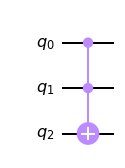

In [15]:
circ = q(3)
circ.ccx(0, 1, 2)
milk(circ)

And for higher $n$, $6$ for example, the circuit would take this form.

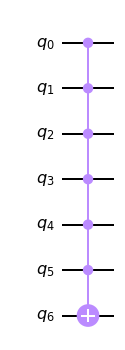

In [47]:
circ = q(7)
circ.mct(list(range(6)), 6)
milk(circ)

The cost for the Qiskit implementation of $CnX$ gate from $n = 2$ to $n = 11$ are listed above in terms of the basic operations ($CX$ and $U3$). Note that the general cost is defined as $10CX + U3$.

n | CX | U3 | General Cost 
--- | --- | --- | --- 
2 | 6 | 8 | 68 
3 | 20 | 22 | 222
4 | 44 | 46 | 486
5 | 92 | 94 | 1014
6 | 188 | 190 | 2070
7 | 380 | 382 | 4182
8 | 764 | 766 | 8406
9 | 1532 | 1534 | 16854
10 | 3068 | 3070 | 33750
11 | 6140 | 6142 | 67542

As outlined in Corolllary 7.1 [3]. The number of $CX$ grows by $3\cdot 2^{n-1} - 4$, and $U3$ grows by $3\cdot 2^{n-1} - 2$. Overall, we see an $O(2^n)$ complexity of the general cost.

Our technique takes advantage of the superposition identity that

$$H Z H = X$$

For an arbitrary $CnX$, we split the control into two groups (one controlled by $H$, and one controlled by $Z$). If we defined the number of control bits on the $H$ gates as $a$, we have the circuit $C(a)H - C(n-a)Z - C(a)H$. An example of $n = 7, a = 3$ is shown below.

In [3]:
98300*10+98302

1081302

In [1]:
3*2**(15)-4

98300

In [2]:
3*2**(15)-2

98302

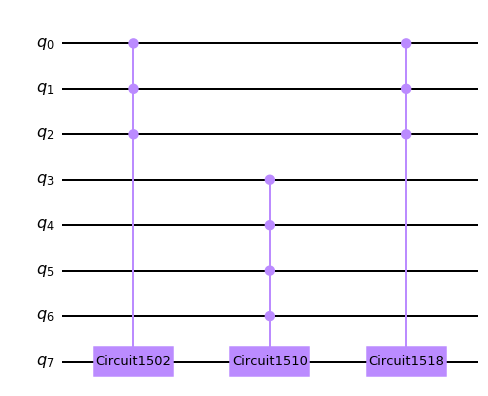

In [49]:
circ = q(8)
circ = control_unitary(circ, H, [0, 1, 2], 7)
circ = control_unitary(circ, Z, [3, 4, 5, 6], 7)
circ = control_unitary(circ, H, [0, 1, 2], 7)

milk(circ)

The two outer most gates are $C3H$, and the middle gate is $C4Z$. Together they create $C7X$ with a negative phase in 7 columns of the unitary. In general, the number of negative phase in the unitary has the form $2^a - 1$. Although $a$ can be varied, for each $n$, there exists a unique value of $a$ that is optimal for the respective circuit. We run and tested out all the different combination of $n$s and $a$s. And we generate the set of opimal combinations shown below.

n | H-a | CX | U3 | General Cost 
--- | --- | --- | --- | --- 
2 | 1 | 3 | 4 | 34
3 | 1 | 6 | 7 | 67
4 | 1 | 20 | 25 | 225
5 | 2 | 34 | 53 | 393
6 | 2 | 50 | 72 | 572
7 | 3 | 70 | 101 | 801
8 | 4 | 102 | 143 | 1163
9 | 4 | 146 | 196 | 1656
10 | 4 | 222 | 286 | 2506
11 | 5 | 310 | 395 | 3495

### Implementing the General Circuit

The circuit will be implemented recursively using three base cases. When $n = 1$, when have the $CX$ gate. When $n = 2$, we have the below structure.

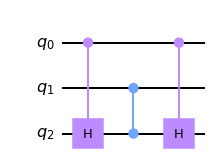

In [54]:
milk(CnX(2))

$n = 3$

cx: 6
u3: 7
Total cost: 67


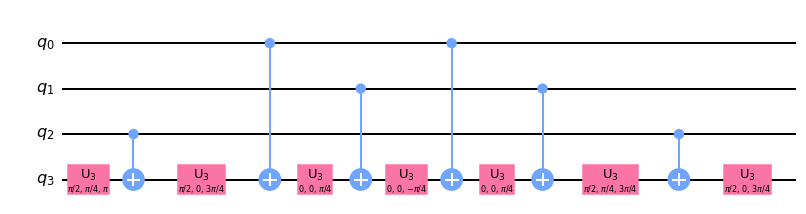

In [58]:
dtp(CnX(3))

We sketch the following for the general circuit of $CnX$

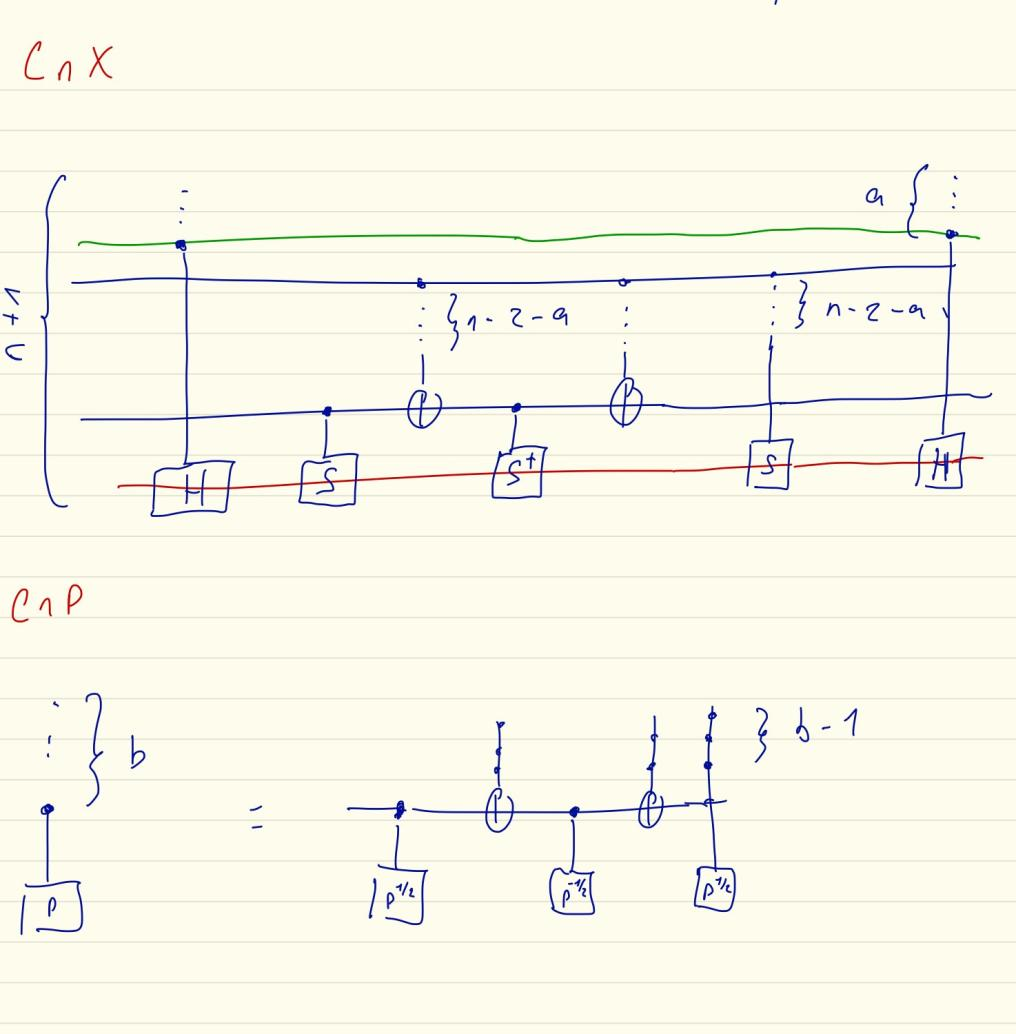

We also provide the qiskit code implementation of for the general $CnX$ below. At the end is the list of the best implementation for each CnX gate. To use, simply assign ```best[n] ``` to an object and use like a normal QuantumCircuit. Note that $n$ represents the number of controls in the desired $CnX$.

###### CnX/CnP (Multiple-controlled Not modulo phase shift circuit)

In [21]:
def CnX(n, control_list = None, target = None, circ = None, theta = 1):
    
    """
    Create a CnX modulo phase shift gate
    
    Parameters:
    -----------
    n: int
        Number of control bits
    control_list: list
        Index of control bits on inputted circuit (if any)
    target: int
        Index of control bits on inputted circuit (if any)
    circ: QuantumCircuit
        Inputted circuit to compose CnX on
    theta: int
        1/theta power X n-bit controlled circuit
        
    Returns:
    --------
    circ: QuantumCircuit
        CnX modulo phase shift gate
        
    """
    
    # Build New Circuit
    if circ == None:
        circ = q(n+1)
        control_list = list(range(n))
        target = n
    
    # Base Case
    if n == 1:
        
        circ.cx(*control_list, target)
        
        return circ
    
    if n==2:
        circ.ch(control_list[0], target)
        circ.cz(control_list[1], target)
        circ.ch(control_list[0], target)
        
        return circ
    
    if n == 3:
        circ.rcccx(*control_list, target)
        
        return circ
    
    # New Case
    
    # CH
    circ.ch(control_list[0], target)
    
    # CP2
    circ = control_phase(circ, theta*2, control_list[-1], target)
    
    # C(n-2)X
    circ = CnX(n-2, control_list[1:-1], control_list[-1], circ)
    
    # -CP2
    circ = control_phase(circ, -theta*2, control_list[-1], target)
    
    # C(n-2)X
    circ = CnX(n-2, control_list[1:-1], control_list[-1], circ)
    
    # CnP
    circ = CnP(n-2, control_list[1:-1], target, circ, theta*2)
    
    # CH
    circ.ch(control_list[0], target)
    
    return circ

def CnP(n, control_list = None, target = None, circ = None, theta = 1):
    
    """
    Create a CnP modulo phase shift gate
    
    Parameters:
    -----------
    n: int
        Number of control bits
    control_list: list
        Index of control bits on inputted circuit (if any)
    target: int
        Index of control bits on inputted circuit (if any)
    circ: QuantumCircuit
        Inputted circuit to compose CnP on
    theta: int
        1/theta power Z n-bit controlled circuit
        
    Returns:
    --------
    circ: QuantumCircuit
        CnP modulo phase shift gate
        
    """
    
    # Build New Circuit
    if circ == None:
        circ = q(n+1)
        control_list = list(range(n))
        target = n
    
    # Base Case
    if n ==1:
        circ = control_phase(circ, theta, control_list, target)
        
        return circ 
    
    # New Case
    
    # CP
    circ = control_phase(circ, theta*2, control_list[-1], target)
    
    # C(n-1)X
    circ = CnX(n-1, control_list[:-1], control_list[-1], circ)
    
    # -CP
    circ = control_phase(circ, -theta*2, control_list[-1], target)
    
    # C(n-1)X
    circ = CnX(n-1, control_list[:-1], control_list[-1], circ)
    
    # C(n-1)P
    circ = CnP(n-1, control_list[:-1], target, circ, theta*2)
    
    return circ

###### CnH / Multi-Hadamard Composition

In [22]:
def CnH(n, control_list = None, target = None, circ = None, theta = 1):
    
    """
    Create a CnH modulo phase shift gate
    
    Parameters:
    -----------
    n: int
        Number of control bits
    control_list: list
        Index of control bits on inputted circuit (if any)
    target: int
        Index of control bits on inputted circuit (if any)
    circ: QuantumCircuit
        Inputted circuit to compose CnH on
    theta: int
        1/theta power H n-bit controlled circuit
        
    Returns:
    --------
    circ: QuantumCircuit
        CnH modulo phase shift gate
        
    """
    
    # Build New Circuit
    if circ == None:
        circ = q(n+1)
        control_list = list(range(n))
        target = n
    
    # Base Case
    
    if n ==1 and theta ==1:
        circ.ch(control_list, target)
        
        return circ
    
    if n ==1:
        circ.unitary(cu_matrix(2, 0, 1, Hp(1/theta)), [control_list, target])
        
        return circ 
    
    # New Case
    
    # CH
    circ.unitary(cu_matrix(2, 0, 1, Hp(1/(theta*2))), [control_list[-1], target])
    
    # C(n-1)X
    circ = CnX(n-1, control_list[:-1], control_list[-1], circ)
    
    # CH
    circ.unitary(cu_matrix(2, 0, 1, Hp(-1/(theta*2))), [control_list[-1], target])
    
    # C(n-1)X
    circ = CnX(n-1, control_list[:-1], control_list[-1], circ)
    
    # C(n-1)P
    circ = CnH(n-1, control_list[:-1], target, circ, theta*2)
    
    return circ

def h_relief(n, no_h, return_circ = False):
    
    """
    Implementing the general CaH-C(n-a)Z-CaH architecture
    
    Paramters:
    ----------
    n: int
        Total number of control bits
    no_h: int
        Total number of control bits for the CnH gate
    return_circ: bool
        Return circuit as a QuantumCircuit object
        
    Returns:
    --------
    circ: QuantumCircuit
        Circuit with CnX and Hadamard Relief
    
    """
    
    # n is the number of control qubit
    # no_h is the number of control qubit on the side hadamard
    circ = q(n+1)
    circ= CnH(no_h, list(range(no_h)), n, circ)

    circ = CnP(n-no_h, list(range(no_h, n)), n, circ)
    circ= CnH(no_h, list(range(no_h)), n, circ)

    '''# Test for accuracy
    test = get(circ, nice = False)
    unitary_check(test)'''
    
    if return_circ:
        return circ
    
    dtp(circ, nice = False)

In [23]:
### List of opimal combinations

best = [None, None, CnX(2), CnX(3), CnX(4), h_relief(5, 2, return_circ = True), h_relief(6, 2, return_circ = True), 
 h_relief(7, 3, return_circ = True), h_relief(8, 4, return_circ = True), h_relief(9, 4, return_circ = True), 
 h_relief(10, 4, return_circ = True), h_relief(11, 5, return_circ = True), h_relief(12, 6, return_circ = True)]

### Postulate for Complexity of the General Cost

We have two lists below showing the number of $U3$ and $CX$ used for the qiskit technique and our technique

In [24]:
## Qiskit

cx_q = np.array([6, 20, 44, 92, 188, 380, 764, 1532, 3068, 6140])
u3_q = np.array([8, 22, 46, 94, 190, 382, 766, 1534, 3070, 6142])

## Our

cx_o = np.array([3, 6, 20, 34, 50, 70, 102, 146, 222, 310])
u3_o = np.array([4, 7, 25, 53, 72, 101, 143, 196, 286, 395])

We find the common ratios by taking $a_{n+1}/a_n$, and taking the average of these ratio when $n > 3$ to mitigate the impact of the additive factor.

In [25]:
## Qiskit

rat_1 = cx_q[1:] / cx_q[:-1]
rat_1 = np.mean(rat_1[3:])

rat_2 = u3_q[1:] / u3_q[:-1]
rat_2 = np.mean(rat_2[3:])

## Our

rat_3 = cx_o[1:] / cx_o[:-1]
rat_3 = np.mean(rat_3[3:])

rat_4 = u3_o[1:] / u3_o[:-1]
rat_4 = np.mean(rat_4[3:])

In [26]:
rat_1, rat_2, rat_3, rat_4

(2.014071920253367, 2.00693412107478, 1.4460079971764097, 1.398006975531928)

We see that the geometric ratio of our technique is superior to that of qiskit. In base $2$, we can roughly see the following complexity.

$$CX \approx O(1.446^n) \approx O(2^{\frac{n}{2}})$$

$$U3 \approx O(1.380^n) \approx O(2^{\frac{n}{2}})$$

### Compare and Contrast with the $O(n^2)$ technique in Corollary 7.6 of [3]

Lemma 7.5 shows an example of $C8X$ built using 2 $C7X$ and 1 $C7V$. For our purposes, we can assume that the cost of $C7V$ is equal to that of $C7X$. In actuality, the cost of any CnU gate is much greater than that of $CnX$ gates so therefore this assumption gives us a lower bound of the cost of the circuit.

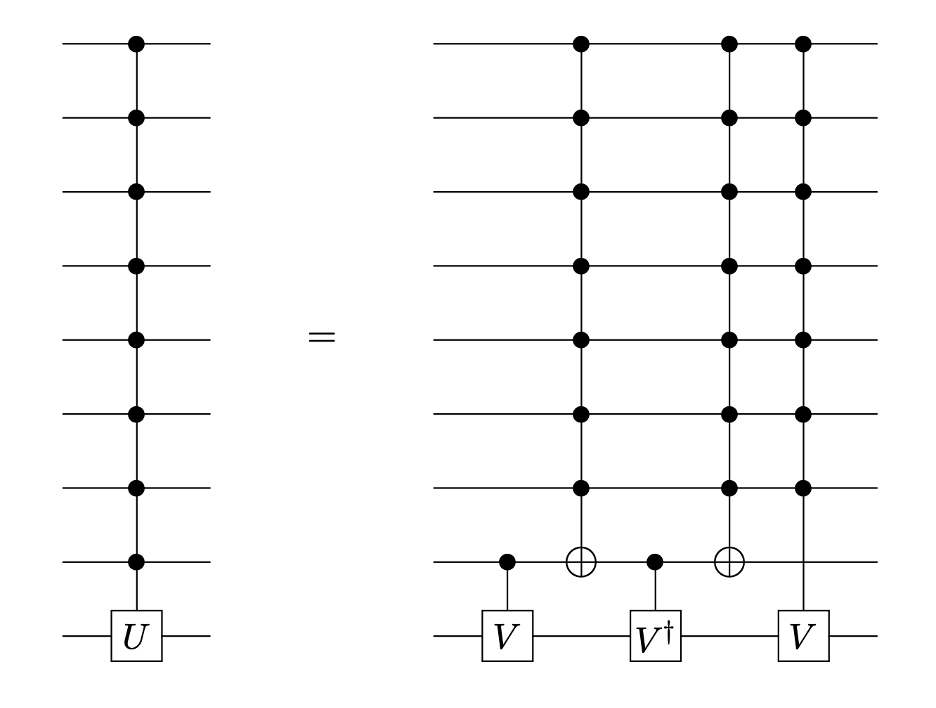

Previous lemmas and corollaries show that these can gates can be broken down further into smaller $C2X$ and $C3X$ gates.

$$\begin{align}C5X &= 12 \ C2X = 12\cdot34 = 408 \\ C7X &= 2 \ C5X + 2 \ C3X = 2\cdot408 + 2\cdot67 = 950 \\ C8X &= 3 \ C7X \end{align}$$

If we let use our implementation of $C2X$ and $C3X$. Then we would have the general cost of $C8X = 2850$. However, as our circuit allow for the use of phase differences, we would also allow this circuit to be used to built bigger examples like shown below.

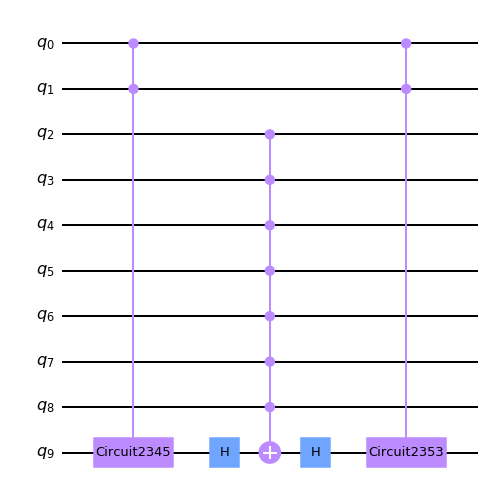

In [93]:
circ = q(10)
circ = control_unitary(circ, H, [0, 1], 9)
circ.h(9)
circ.mct([2, 3, 4, 5, 6, 7, 8], 9)
circ.h(9)
circ = control_unitary(circ, H, [0, 1], 9)

milk(circ)

The $3$ middle gates will have the effect of $C8Z$, and the two gate outside are $C2Z$. This will leads to $C10X$ with phase difference. Now we made one last modification to the implementation of Lemma 7.5. If we look back to the table from before, we can see that our implementation of $C7X$ has a lower than $950$. Because the phase difference does not affect the control operation, we can replace the paper's $C7X$ with ours.

In [100]:
print(1)
dtp(CnH(1), nice = False)
print('\n')
print(2)
dtp(CnH(2), nice = False)
print('\n')
print(3)
dtp(CnH(3), nice = False)

1
cx: 1
u3: 2
Total cost: 12


2
cx: 8
u3: 16
Total cost: 96


3
cx: 18
u3: 31
Total cost: 211


Using the $CnH$ implementation cost of $96$. The lower bound of the general cost of $C8X, C9X, C10X$ with and without phase difference are:

n | H-a  | Our Cost | Lower Bound
--- | --- | --- | ---
8 | 0 | 1163 | 2403
9 | 1 | 1656 | 2427
10 | 2 | 2506 | 2595
11 | 3 | 3495 | 2825

This conclusively shows that our technique is superior for $n = 8, 9, 10, 11$. It's easily provable that this supremacy holds for $n = 5, 6, 7$. 

### References

1. https://arxiv.org/pdf/0803.2316.pdf
2. https://arxiv.org/pdf/1508.03273.pdf
3. https://arxiv.org/pdf/quant-ph/9503016.pdf
4. https://arxiv.org/abs/quant-ph/9508027